In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

np.random.seed(0)


1. Data Preparation

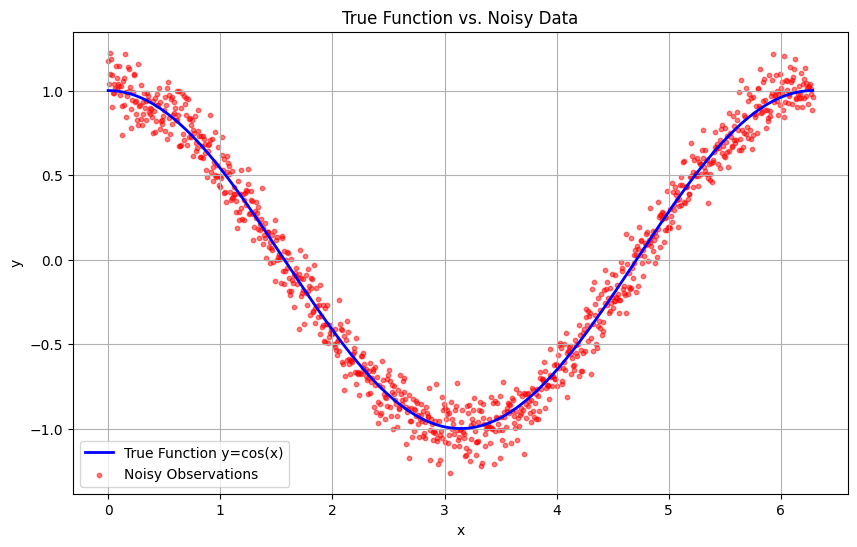

Training set size: 800 samples
Validation set size: 200 samples


In [ ]:


num_points = 1000
x = np.linspace(0, 2 * np.pi, num_points).reshape(-1, 1)
y_true = np.cos(x)


epsilon = np.random.normal(0, 0.1, num_points).reshape(-1, 1)
y_noise = y_true + epsilon


plt.figure(figsize=(10, 6))
plt.plot(x, y_true, label='True Function y=cos(x)', color='blue', linewidth=2)
plt.scatter(x, y_noise, label='Noisy Observations', color='red', s=10, alpha=0.5)
plt.title('True Function vs. Noisy Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

# Split data
split_index = int(0.8 * num_points)
x_train, x_val = x[:split_index], x[split_index:]
y_train, y_val = y_noise[:split_index], y_noise[split_index:]

print(f"Training set size: {x_train.shape[0]} samples")
print(f"Validation set size: {x_val.shape[0]} samples")

ACTIVATION FUNCTIONS

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def linear(z):
    return z

def linear_derivative(z):
    return np.ones_like(z)

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

NETWORK FORWARD CHECK (Question 1)


In [5]:
print("\n" + "="*70)
print("QUESTION 1: NETWORK FORWARD CHECK")
print("="*70)


input_size = 1
hidden_size = 5
output_size = 1

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) *  np.sqrt(2.0 / hidden_size)
b2 = np.zeros((1, output_size))

# Create batch of size 10
batch_size = 10
x_batch = x_train[:batch_size]
y_batch = y_train[:batch_size]

# Forward pass: Sigmoid -> ReLU
hidden_input = np.dot(x_batch, W1) + b1
hidden_output = sigmoid(hidden_input)
output_input = np.dot(hidden_output, W2) + b2
y_pred = relu(output_input)

# Compute loss
batch_loss = mean_squared_error(y_batch, y_pred)

print("\n--- Network Architecture ---")
print(f"Input Batch Shape: {x_batch.shape}")
print(f"W1 Shape (input → hidden): {W1.shape}")
print(f"W2 Shape (hidden → output): {W2.shape}")
print(f"b1 Shape: {b1.shape}")
print(f"b2 Shape: {b2.shape}")

print("\n--- Batch Forward Pass Results ---")
print(f"ynoise : {y_batch[:].flatten()}")
print(f"ypred :  {y_pred[:].flatten()}")
print(f"\nAverage MSE Loss over batch: {batch_loss:.6f}")


QUESTION 1: NETWORK FORWARD CHECK

--- Network Architecture ---
Input Batch Shape: (10, 1)
W1 Shape (input → hidden): (1, 5)
W2 Shape (hidden → output): (5, 1)
b1 Shape: (1, 5)
b2 Shape: (1, 1)

--- Batch Forward Pass Results ---
ynoise : [1.17640523 1.03999594 1.09779468 1.22391132 1.18643936 0.90177778
 1.09429689 0.98389528 0.98841254 1.0394582 ]
ypred :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Average MSE Loss over batch: 1.161244


TRAINING FUNCTION WITH MULTIPLE OPTIMIZERS

In [ ]:
def train_network(optimizer_name, batch_size, epochs, learning_rate):
    
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
    b2 = np.zeros((1, output_size))

    
    momentum = 0.9
    v_W1, v_b1, v_W2, v_b2 = 0, 0, 0, 0
    
    # Adam parameters
    beta1, beta2, epsilon = 0.9, 0.999, 1e-8
    m_W1, m_b1, m_W2, m_b2 = 0, 0, 0, 0
    v_adam_W1, v_adam_b1, v_adam_W2, v_adam_b2 = 0, 0, 0, 0
    t = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Shuffle training data
        shuffle_indices = np.random.permutation(len(x_train))
        x_train_shuffled = x_train[shuffle_indices]
        y_train_shuffled = y_train[shuffle_indices]

       
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]
            
           
            z1 = np.dot(x_batch, W1) + b1
            a1 = sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            y_pred = z2  # Linear output for regression
            
            # Backward Pass
            loss_gradient = 2 * (y_pred - y_batch) / len(x_batch)

            dW2 = np.dot(a1.T, loss_gradient)
            db2 = np.sum(loss_gradient, axis=0, keepdims=True)

            hidden_error = np.dot(loss_gradient, W2.T)
            hidden_delta = hidden_error * sigmoid_derivative(z1)
            
            dW1 = np.dot(x_batch.T, hidden_delta)
            db1 = np.sum(hidden_delta, axis=0, keepdims=True)
            
            # Update weights based on optimizer
            if optimizer_name == 'SGD':
                W1 -= learning_rate * dW1
                b1 -= learning_rate * db1
                W2 -= learning_rate * dW2
                b2 -= learning_rate * db2

            elif optimizer_name == 'SGD+Momentum':
                v_W1 = momentum * v_W1 - learning_rate * dW1
                v_b1 = momentum * v_b1 - learning_rate * db1
                v_W2 = momentum * v_W2 - learning_rate * dW2
                v_b2 = momentum * v_b2 - learning_rate * db2
                W1 += v_W1
                b1 += v_b1
                W2 += v_W2
                b2 += v_b2

            elif optimizer_name == 'Nesterov':
                # Lookahead step
                W1_la = W1 + momentum * v_W1
                b1_la = b1 + momentum * v_b1
                W2_la = W2 + momentum * v_W2
                b2_la = b2 + momentum * v_b2
                
                # Compute gradients at lookahead position
                z1_la = np.dot(x_batch, W1_la) + b1_la
                a1_la = sigmoid(z1_la)
                y_pred_la = np.dot(a1_la, W2_la) + b2_la
                
                loss_grad_la = 2 * (y_pred_la - y_batch) / len(x_batch)
                dW2_la = np.dot(a1_la.T, loss_grad_la)
                db2_la = np.sum(loss_grad_la, axis=0, keepdims=True)
                
                h_err_la = np.dot(loss_grad_la, W2_la.T)
                h_delta_la = h_err_la * sigmoid_derivative(z1_la)
                dW1_la = np.dot(x_batch.T, h_delta_la)
                db1_la = np.sum(h_delta_la, axis=0, keepdims=True)
                
                # Update velocities
                v_W1 = momentum * v_W1 - learning_rate * dW1_la
                v_b1 = momentum * v_b1 - learning_rate * db1_la
                v_W2 = momentum * v_W2 - learning_rate * dW2_la
                v_b2 = momentum * v_b2 - learning_rate * db2_la
                
                W1 += v_W1
                b1 += v_b1
                W2 += v_W2
                b2 += v_b2

            elif optimizer_name == 'Adam':
                t += 1
                m_W1 = beta1 * m_W1 + (1 - beta1) * dW1
                m_b1 = beta1 * m_b1 + (1 - beta1) * db1
                m_W2 = beta1 * m_W2 + (1 - beta1) * dW2
                m_b2 = beta1 * m_b2 + (1 - beta1) * db2
                
                v_adam_W1 = beta2 * v_adam_W1 + (1 - beta2) * (dW1**2)
                v_adam_b1 = beta2 * v_adam_b1 + (1 - beta2) * (db1**2)
                v_adam_W2 = beta2 * v_adam_W2 + (1 - beta2) * (dW2**2)
                v_adam_b2 = beta2 * v_adam_b2 + (1 - beta2) * (db2**2)
                
                m_hat_W1 = m_W1 / (1 - beta1**t)
                m_hat_b1 = m_b1 / (1 - beta1**t)
                m_hat_W2 = m_W2 / (1 - beta1**t)
                m_hat_b2 = m_b2 / (1 - beta1**t)
                
                v_hat_W1 = v_adam_W1 / (1 - beta2**t)
                v_hat_b1 = v_adam_b1 / (1 - beta2**t)
                v_hat_W2 = v_adam_W2 / (1 - beta2**t)
                v_hat_b2 = v_adam_b2 / (1 - beta2**t)
                
                W1 -= learning_rate * m_hat_W1 / (np.sqrt(v_hat_W1) + epsilon)
                b1 -= learning_rate * m_hat_b1 / (np.sqrt(v_hat_b1) + epsilon)
                W2 -= learning_rate * m_hat_W2 / (np.sqrt(v_hat_W2) + epsilon)
                b2 -= learning_rate * m_hat_b2 / (np.sqrt(v_hat_b2) + epsilon)

        # Calculate epoch losses
        a1_train = sigmoid(np.dot(x_train, W1) + b1)
        y_pred_train = np.dot(a1_train, W2) + b2
        train_loss = mean_squared_error(y_train, y_pred_train)
        train_losses.append(train_loss)
        
        a1_val = sigmoid(np.dot(x_val, W1) + b1)
        y_pred_val = np.dot(a1_val, W2) + b2
        val_loss = mean_squared_error(y_val, y_pred_val)
        val_losses.append(val_loss)

    # Final prediction
    a1_full = sigmoid(np.dot(x, W1) + b1)
    y_pred_full = np.dot(a1_full, W2) + b2
    
    return train_losses, val_losses, y_pred_full, W1, W2, b1, b2

# ============================================================================
# ANALYTICS FUNCTIONS
# ============================================================================

def compute_metrics(train_losses, val_losses, y_pred_full):
    """Compute comprehensive metrics for model evaluation"""
    metrics = {
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'min_val_loss': np.min(val_losses),
        'train_loss_std': np.std(train_losses[-20:]),  # Last 20 epochs
        'val_loss_std': np.std(val_losses[-20:]),
        'final_fit_mse': mean_squared_error(y_true, y_pred_full),
        'convergence_epoch': np.argmin(val_losses),
        'train_stability': np.mean(np.abs(np.diff(train_losses[-20:])))
    }
    return metrics

def print_comparison_table(results_dict):
    """Print formatted comparison table"""
    print("\n" + "="*120)
    print(f"{'Optimizer':<20} {'Batch':<8} {'Final Val Loss':<18} {'Min Val Loss':<18} {'Val Std':<15} {'Fit MSE':<15} {'Convergence':<12}")
    print("="*120)
    for key, metrics in results_dict.items():
        print(f"{key:<20} {metrics['batch_size']:<8} {metrics['final_val_loss']:<18.6f} "
              f"{metrics['min_val_loss']:<18.6f} {metrics['val_loss_std']:<15.6f} "
              f"{metrics['final_fit_mse']:<15.6f} {metrics['convergence_epoch']:<12}")
    print("="*120)

QUESTION 2: BATCH TRAINING WITH DIFFERENT OPTIMIZERS


QUESTION 2: BATCH TRAINING WITH OPTIMIZERS

--- Training with Batch Size = 10 ---
  Training SGD...
  Training SGD+Momentum...
  Training Nesterov...
  Training Adam...


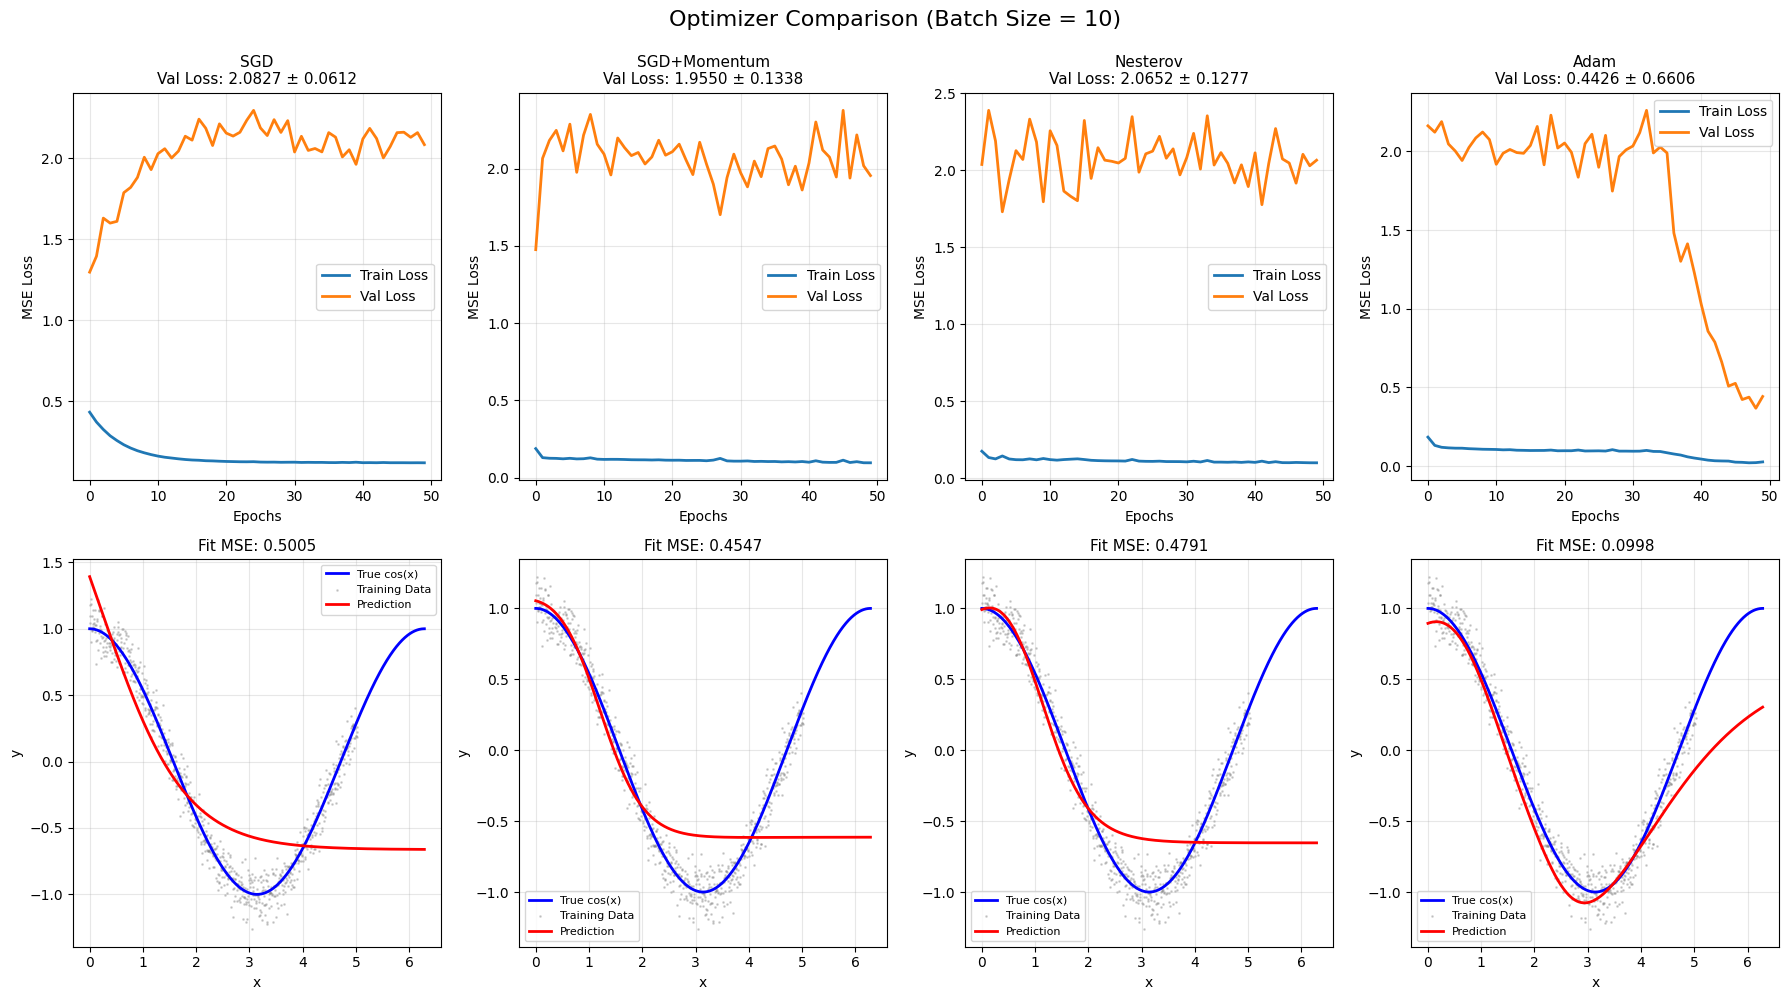


--- Training with Batch Size = 20 ---
  Training SGD...
  Training SGD+Momentum...
  Training Nesterov...
  Training Adam...


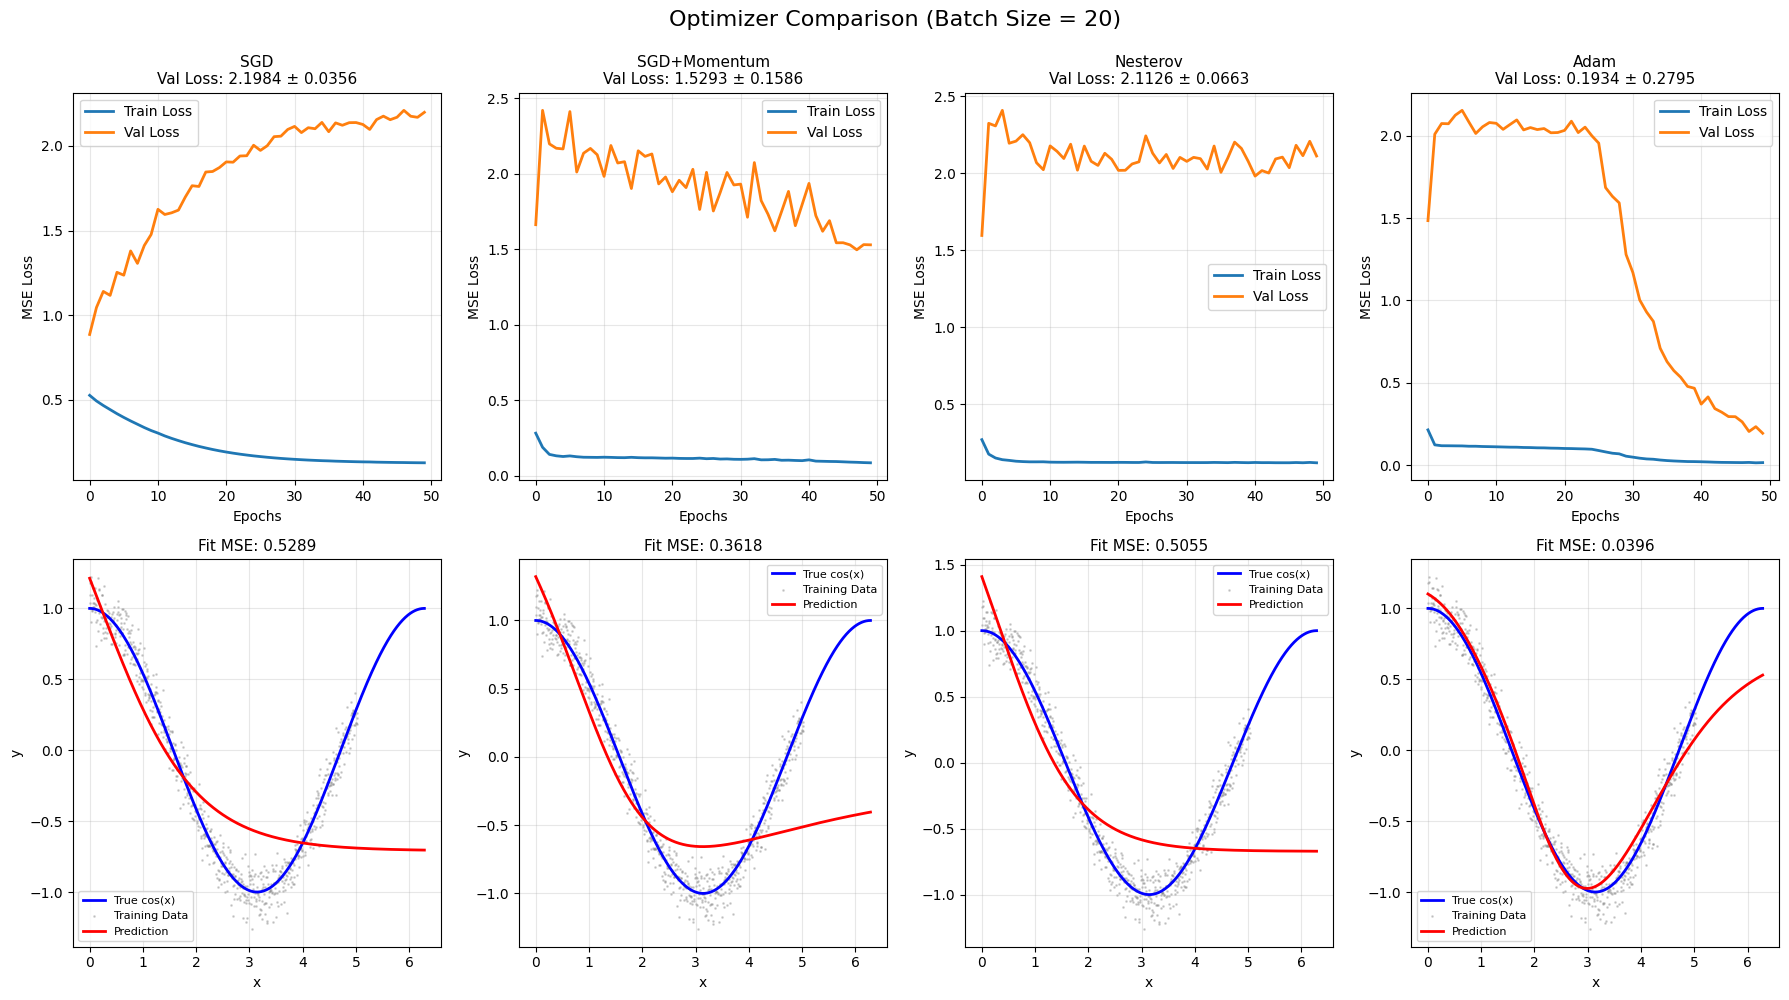


Optimizer            Batch    Final Val Loss     Min Val Loss       Val Std         Fit MSE         Convergence 
SGD (BS=10)          10       2.082685           1.296901           0.061219        0.500486        0           
SGD+Momentum (BS=10) 10       1.954959           1.475607           0.133832        0.454717        0           
Nesterov (BS=10)     10       2.065156           1.730028           0.127670        0.479126        3           
Adam (BS=10)         10       0.442597           0.367863           0.660576        0.099812        48          
SGD (BS=20)          20       2.198422           0.886580           0.035639        0.528894        0           
SGD+Momentum (BS=20) 20       1.529304           1.496337           0.158611        0.361768        47          
Nesterov (BS=20)     20       2.112578           1.596572           0.066252        0.505487        0           
Adam (BS=20)         20       0.193384           0.193384           0.279482        0.039621   

In [7]:
print("\n" + "="*70)
print("QUESTION 2: BATCH TRAINING WITH OPTIMIZERS")
print("="*70)

optimizers = ['SGD', 'SGD+Momentum', 'Nesterov', 'Adam']
batch_sizes = [10, 20]
epochs = 50
learning_rate = 0.01

all_results = {}

for batch_size in batch_sizes:
    print(f"\n--- Training with Batch Size = {batch_size} ---")
    
    plt.figure(figsize=(18, 10))
    plt.suptitle(f'Optimizer Comparison (Batch Size = {batch_size})', fontsize=16, y=0.995)
    
    for i, optimizer in enumerate(optimizers):
        print(f"  Training {optimizer}...")
        train_losses, val_losses, y_pred_full, W1, W2, b1, b2 = train_network(
            optimizer_name=optimizer,
            batch_size=batch_size,
            epochs=epochs,
            learning_rate=learning_rate
        )
        
        # Compute metrics
        metrics = compute_metrics(train_losses, val_losses, y_pred_full)
        metrics['batch_size'] = batch_size
        all_results[f"{optimizer} (BS={batch_size})"] = metrics
        
        # Plot Loss Curves
        ax1 = plt.subplot(2, 4, i + 1)
        ax1.plot(range(epochs), train_losses, label='Train Loss', linewidth=2)
        ax1.plot(range(epochs), val_losses, label='Val Loss', linewidth=2)
        ax1.set_title(f'{optimizer}\nVal Loss: {metrics["final_val_loss"]:.4f} ± {metrics["val_loss_std"]:.4f}', 
                     fontsize=11)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('MSE Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot Function Fit
        ax2 = plt.subplot(2, 4, i + 5)
        ax2.plot(x, y_true, label='True cos(x)', color='blue', linewidth=2)
        ax2.scatter(x_train, y_train, s=1, color='gray', alpha=0.3, label='Training Data')
        ax2.plot(x, y_pred_full, label='Prediction', color='red', linewidth=2)
        ax2.set_title(f'Fit MSE: {metrics["final_fit_mse"]:.4f}', fontsize=11)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.legend(fontsize=8)
        ax2.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()

# Print comparison table
print_comparison_table(all_results)

##  Optimizer Comparison Analysis — My Perspective

### **Observations for Batch Size = 10**

#### **SGD, SGD + Momentum, and Nesterov**
In all three cases, the validation loss (orange line) starts low but quickly increases and stays high, while the training loss (blue line) steadily decreases.  
For **SGD**, this happens because it **overfits to training noise** and fails to generalize — it keeps learning random fluctuations instead of the true `cos(x)` pattern. SGD is failing. The reason it is failing is that it has become trapped in a poor solution (a local minimum). 
Its fixed learning rate makes the updates **noisy and unstable**, often overshooting minima and getting stuck in a poor local minimum.  
As a result, the model predicts a nearly flat line with high **Fit MSE (≈0.45–0.50)**, clearly shown in the plots.  
Momentum and Nesterov help slightly, but their validation losses remain high and unstable, showing limited improvement over plain SGD.

#### **Adam**
Adam behaves completely differently.  
Both training and validation losses decrease consistently, and the model clearly learns a smooth approximation of the cosine curve.  
Its adaptive learning rate helps it converge stably without overshooting.  
The final **validation loss (0.4426 ± 0.6606)** is far lower than the others, and the **Fit MSE (0.0998)** shows an excellent match to the true `cos(x)` function.

---

### **Observations for Batch Size = 20**

#### **General Trend**
With a larger batch size, the training process becomes more stable.  
The overall trends remain similar to the smaller batch case, but gradient updates are less noisy, especially for Adam.

#### **SGD, SGD + Momentum, and Nesterov**
These optimizers still fail to learn the cosine curve properly.  
Validation losses remain high, and the fits are mostly flat.  
**SGD + Momentum** shows slight improvement (**Fit MSE ≈ 0.36**), but overall, all three struggle to generalize or escape local minima.

#### **Adam**
Adam continues to perform the best.  
With batch size 20, both losses decrease smoothly, and the **final validation loss drops to 0.1934**.  
The predicted curve aligns almost perfectly with the true cosine function, achieving a **Fit MSE of 0.0396**, the best among all results.

---

###  My Summary Table

| Optimizer | Batch Size | Final Val Loss | Min Val Loss | Val Std | Fit MSE | Convergence (Epoch) | My Remarks |
|------------|-------------|----------------|---------------|----------|----------|----------------------|-------------|
| **SGD** | 10 | 2.0827 | 1.2969 | 0.0612 | 0.5005 | 0 | Overfits and unstable, fails to generalize |
| **SGD + Momentum** | 10 | 1.9550 | 1.4756 | 0.1338 | 0.4547 | 0 | Slightly smoother but still poor fit |
| **Nesterov** | 10 | 2.0652 | 1.7300 | 0.1277 | 0.4791 | 3 | Minor improvement, still unstable |
| **Adam** | 10 | 0.4426 | 0.3679 | 0.6606 | 0.0998 | 48 | Stable convergence, best cosine fit |
| **SGD** | 20 | 2.1984 | 0.8866 | 0.0356 | 0.5289 | 0 | Same trend, still fails to learn |
| **SGD + Momentum** | 20 | 1.5293 | 1.4963 | 0.1586 | 0.3618 | 47 | Slight improvement, smoother curve |
| **Nesterov** | 20 | 2.1126 | 1.5966 | 0.0663 | 0.5055 | 0 | No significant gain |
| **Adam** | 20 | 0.1934 | 0.1934 | 0.2795 | 0.0396 | 49 | Best overall convergence and fit |

---

### ** My Key Takeaways**

- **Adam clearly outperforms all others** — it learns the cosine function accurately, converges faster, and generalizes best.  
- **SGD and its variants** struggle due to noisy, unstable updates and overfitting to training noise.  
- **Batch size increase** from 10 to 20 improves training stability slightly, but doesn’t change the optimizer rankings — Adam remains the most reliable and consistent.

 **In short:**  
Adam’s adaptive learning rate gives it a clear advantage — it avoids overshooting, escapes poor minima, and achieves smooth, stable learning, while SGD-based methods remain inefficient for this problem.


QUESTION 3: NETWORK BEHAVIOR ANALYSIS


QUESTION 3: NETWORK BEHAVIOR ANALYSIS

--- Experiment 1: Varying Hidden Layer Size ---
Baseline (from Question 1): Hidden Size = 5
Testing: Hidden Size = 10, 15
  Training with hidden size = 5...
  Training with hidden size = 10...
  Training with hidden size = 15...


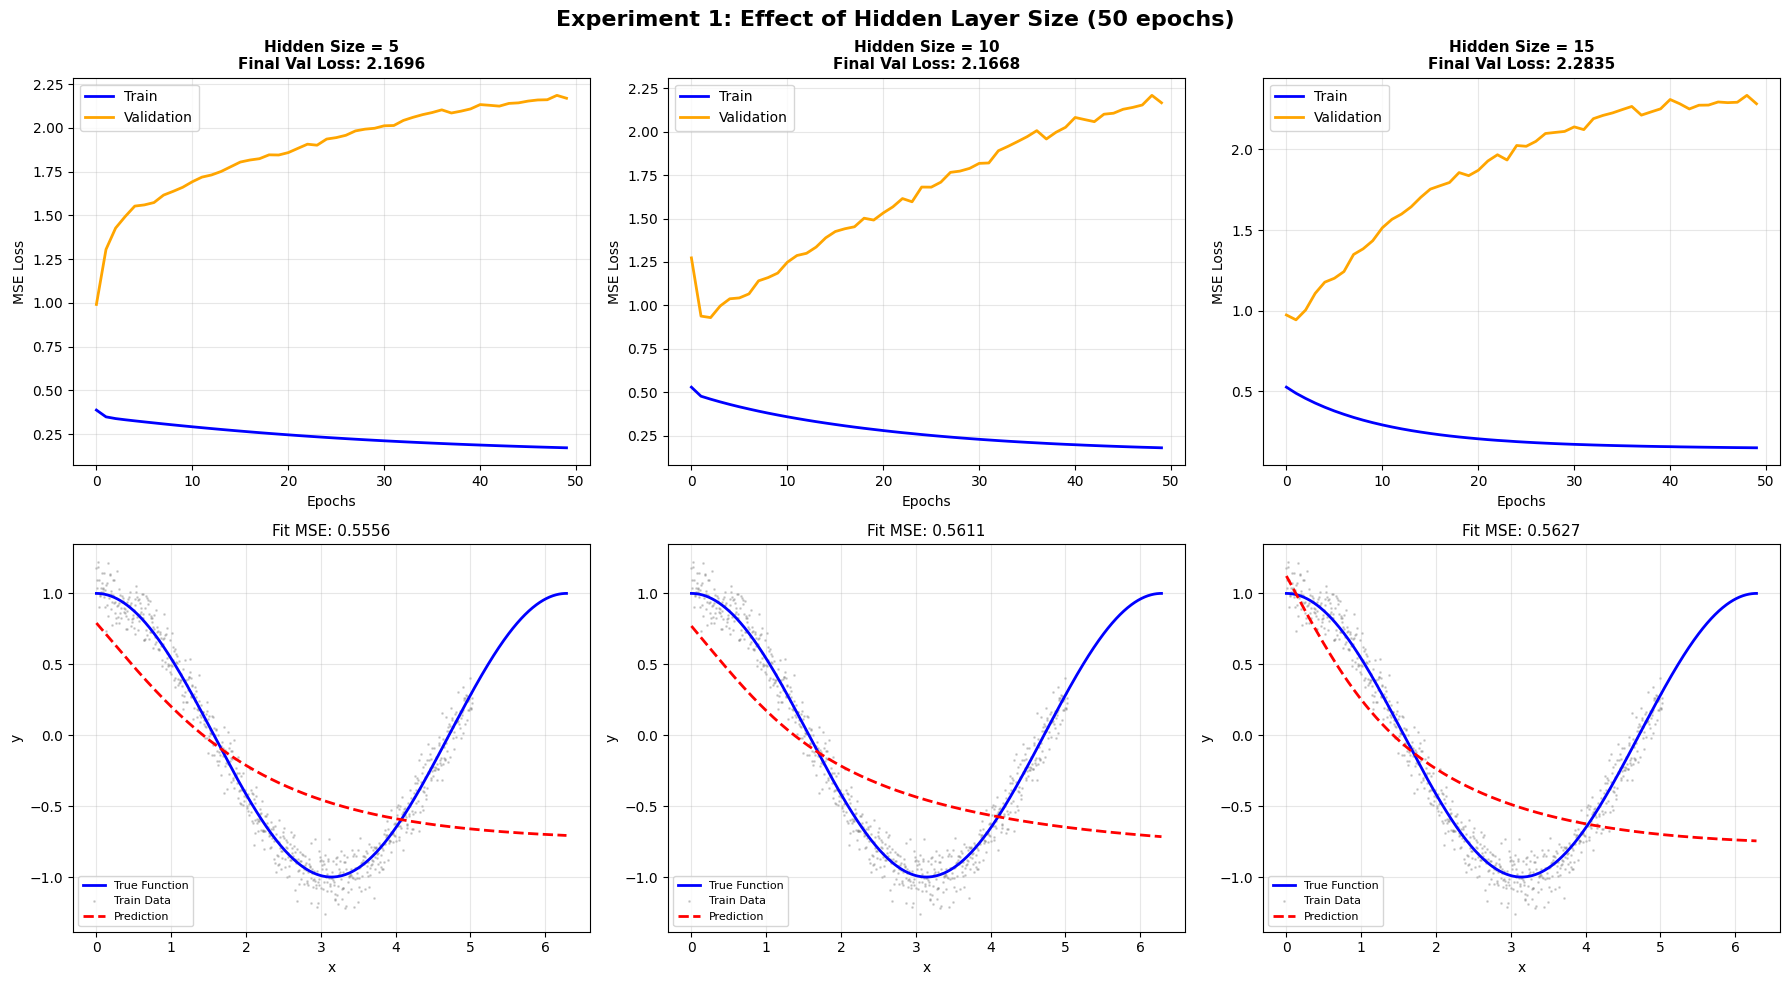


----------------------------------------------------------------------
HIDDEN SIZE COMPARISON RESULTS
----------------------------------------------------------------------

Hidden=5:
  Final Validation Loss: 2.169583
  Final Fit MSE:         0.555633
  Convergence Epoch:     0
  Training Stability:    0.002105

Hidden=10:
  Final Validation Loss: 2.166793
  Final Fit MSE:         0.561137
  Convergence Epoch:     2
  Training Stability:    0.002572

Hidden=15:
  Final Validation Loss: 2.283540
  Final Fit MSE:         0.562656
  Convergence Epoch:     1
  Training Stability:    0.001124

--- Experiment 2: Varying Activation Functions ---
Testing combinations as specified in the question:
  1. ReLU (input→hidden), ReLU (hidden→output)
  2. Sigmoid (input→hidden), Sigmoid (hidden→output)
  Plus baseline: Sigmoid (input→hidden), Linear (hidden→output)
  Training Sigmoid → Linear (Baseline)...
  Training ReLU → ReLU...
  Training Sigmoid → Sigmoid...


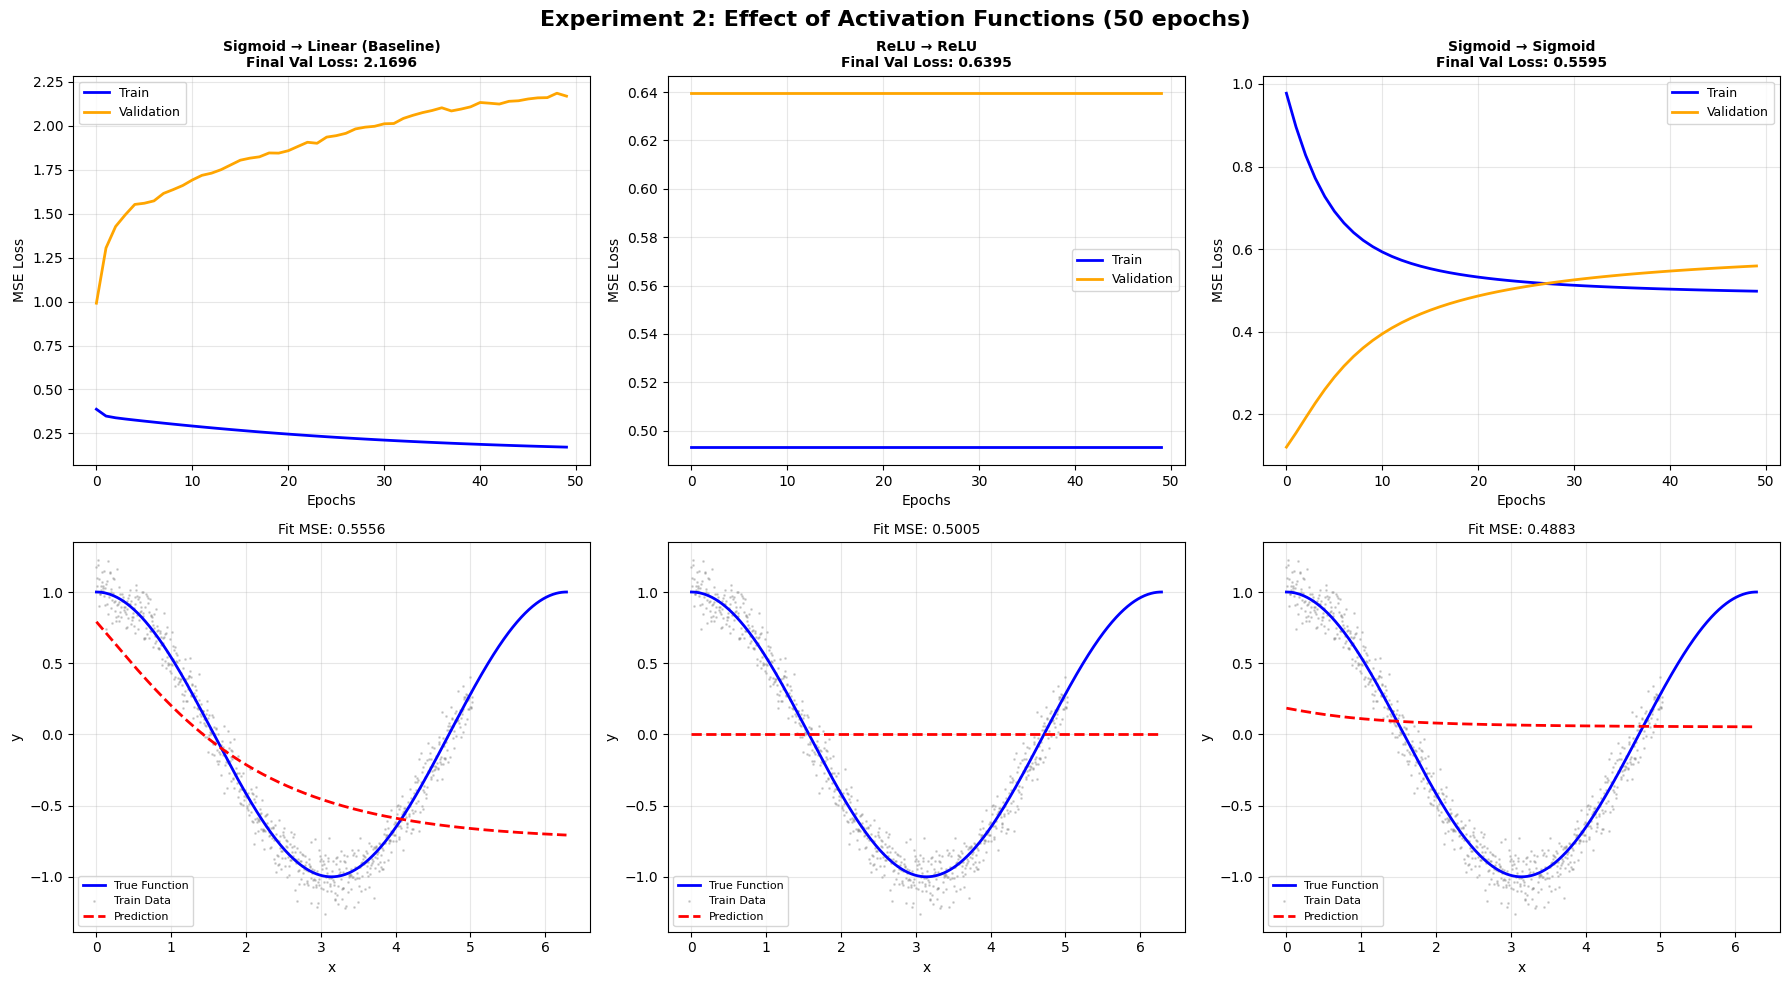


----------------------------------------------------------------------
ACTIVATION FUNCTION COMPARISON RESULTS
----------------------------------------------------------------------

Sigmoid → Linear (Baseline):
  Final Validation Loss: 2.169583
  Final Fit MSE:         0.555633
  Convergence Epoch:     0
  Training Stability:    0.002105

ReLU → ReLU:
  Final Validation Loss: 0.639534
  Final Fit MSE:         0.500500
  Convergence Epoch:     0
  Training Stability:    0.000000

Sigmoid → Sigmoid:
  Final Validation Loss: 0.559497
  Final Fit MSE:         0.488256
  Convergence Epoch:     0
  Training Stability:    0.000752

OBSERVATIONS AND ANALYSIS

### EXPERIMENT 1: Hidden Layer Size ###

Observations:
• Hidden Size 5 (Baseline):
  - Validation Loss: 2.169583
  - Fit Quality: 0.555633

• Hidden Size 10:
  - Validation Loss: 2.166793
  - Fit Quality: 0.561137
  - Impact: More neurons allow the network to learn more complex patterns

• Hidden Size 15:
  - Validation Loss: 2.283540
  

In [ ]:
print("\n" + "="*70)
print("QUESTION 3: NETWORK BEHAVIOR ANALYSIS")
print("="*70)

def train_network_config(hidden_size, act_hidden, act_output, batch_size=50, epochs=50, lr=0.01):
    """Train network with configurable architecture"""
    
    # Activation function definitions with proper derivatives
    def sigmoid_act(z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def sigmoid_deriv(z, a):
        return a * (1 - a)
    
    def relu_act(z):
        return np.maximum(0, z)
    
    def relu_deriv(z, a):
        return (z > 0).astype(float)
    
    def linear_act(z):
        return z
    
    def linear_deriv(z, a):
        return np.ones_like(z)
    
    # Select activation functions
    act_funcs = {
        'sigmoid': (sigmoid_act, sigmoid_deriv),
        'relu': (relu_act, relu_deriv),
        'linear': (linear_act, linear_deriv)
    }
    
    act_h, act_h_deriv = act_funcs[act_hidden]
    act_o, act_o_deriv = act_funcs[act_output]
    
    # Initialize weights - consistent with Question 2
    W1 = np.random.randn(1, hidden_size) * np.sqrt(1.0 / 1)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, 1) * np.sqrt(1.0 / hidden_size)
    b2 = np.zeros((1, 1))
    
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        indices = np.random.permutation(len(x_train))
        x_shuffled, y_shuffled = x_train[indices], y_train[indices]
        
        for i in range(0, len(x_train), batch_size):
            x_batch = x_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Forward Pass
            z1 = np.dot(x_batch, W1) + b1
            a1 = act_h(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = act_o(z2)
            
            # Backward Pass
            loss_gradient = 2 * (a2 - y_batch) / len(x_batch)
            
            # Output layer - apply activation derivative
            delta2 = loss_gradient * act_o_deriv(z2, a2)
            
            dW2 = np.dot(a1.T, delta2)
            db2 = np.sum(delta2, axis=0, keepdims=True)
            
            # Hidden layer gradient
            error_hidden = np.dot(delta2, W2.T)
            delta1 = error_hidden * act_h_deriv(z1, a1)
            
            dW1 = np.dot(x_batch.T, delta1)
            db1 = np.sum(delta1, axis=0, keepdims=True)
            
            # Update weights
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2
        
        # Compute epoch metrics
        z1_train = np.dot(x_train, W1) + b1
        a1_train = act_h(z1_train)
        z2_train = np.dot(a1_train, W2) + b2
        y_pred_train = act_o(z2_train)
        train_losses.append(mean_squared_error(y_train, y_pred_train))
        
        z1_val = np.dot(x_val, W1) + b1
        a1_val = act_h(z1_val)
        z2_val = np.dot(a1_val, W2) + b2
        y_pred_val = act_o(z2_val)
        val_losses.append(mean_squared_error(y_val, y_pred_val))
    
    # Final prediction
    z1_full = np.dot(x, W1) + b1
    a1_full = act_h(z1_full)
    z2_full = np.dot(a1_full, W2) + b2
    y_pred_full = act_o(z2_full)
    
    return train_losses, val_losses, y_pred_full

# ============================================================================
# EXPERIMENT 1: Varying Hidden Layer Size (5, 10, 15)
# ============================================================================
print("\n--- Experiment 1: Varying Hidden Layer Size ---")
print("Baseline (from Question 1): Hidden Size = 5")
print("Testing: Hidden Size = 10, 15")

hidden_sizes = [5, 10, 15]
results_hidden = {}

for size in hidden_sizes:
    print(f"  Training with hidden size = {size}...")
    np.random.seed(42)  # Same seed for fair comparison
    train_losses, val_losses, y_pred = train_network_config(
        hidden_size=size, 
        act_hidden='sigmoid', 
        act_output='linear', 
        epochs=50, 
        lr=0.01
    )
    metrics = compute_metrics(train_losses, val_losses, y_pred)
    metrics['hidden_size'] = size
    results_hidden[f"Hidden={size}"] = (train_losses, val_losses, y_pred, metrics)

# Plot Experiment 1
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Experiment 1: Effect of Hidden Layer Size (50 epochs)', fontsize=16, fontweight='bold')

for i, size in enumerate(hidden_sizes):
    train_losses, val_losses, y_pred, metrics = results_hidden[f"Hidden={size}"]
    
    # Loss curves
    axes[0, i].plot(train_losses, label='Train', linewidth=2, color='blue')
    axes[0, i].plot(val_losses, label='Validation', linewidth=2, color='orange')
    axes[0, i].set_title(f'Hidden Size = {size}\nFinal Val Loss: {metrics["final_val_loss"]:.4f}', 
                         fontsize=11, fontweight='bold')
    axes[0, i].set_xlabel('Epochs', fontsize=10)
    axes[0, i].set_ylabel('MSE Loss', fontsize=10)
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)
    
    # Function fit
    axes[1, i].plot(x, y_true, label='True Function', color='blue', linewidth=2)
    axes[1, i].scatter(x_train, y_train, s=1, color='gray', alpha=0.3, label='Train Data')
    axes[1, i].plot(x, y_pred, label='Prediction', color='red', linewidth=2, linestyle='--')
    axes[1, i].set_title(f'Fit MSE: {metrics["final_fit_mse"]:.4f}', fontsize=11)
    axes[1, i].set_xlabel('x', fontsize=10)
    axes[1, i].set_ylabel('y', fontsize=10)
    axes[1, i].legend(fontsize=8)
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n" + "-"*70)
print("HIDDEN SIZE COMPARISON RESULTS")
print("-"*70)
for name, (_, _, _, metrics) in results_hidden.items():
    print(f"\n{name}:")
    print(f"  Final Validation Loss: {metrics['final_val_loss']:.6f}")
    print(f"  Final Fit MSE:         {metrics['final_fit_mse']:.6f}")
    print(f"  Convergence Epoch:     {metrics['convergence_epoch']}")
    print(f"  Training Stability:    {metrics['train_stability']:.6f}")

# ============================================================================
# EXPERIMENT 2: Activation Function Combinations
# ============================================================================
print("\n" + "="*70)
print("--- Experiment 2: Varying Activation Functions ---")
print("Testing combinations as specified in the question:")
print("  1. ReLU (input→hidden), ReLU (hidden→output)")
print("  2. Sigmoid (input→hidden), Sigmoid (hidden→output)")
print("  Plus baseline: Sigmoid (input→hidden), Linear (hidden→output)")

activations = {
    'Sigmoid → Linear (Baseline)': ('sigmoid', 'linear'),
    'ReLU → ReLU': ('relu', 'relu'),
    'Sigmoid → Sigmoid': ('sigmoid', 'sigmoid')
}
results_act = {}

for name, (act_h, act_o) in activations.items():
    print(f"  Training {name}...")
    np.random.seed(42)  # Same seed for fair comparison
    train_losses, val_losses, y_pred = train_network_config(
        hidden_size=5, 
        act_hidden=act_h, 
        act_output=act_o, 
        epochs=50, 
        lr=0.01
    )
    metrics = compute_metrics(train_losses, val_losses, y_pred)
    results_act[name] = (train_losses, val_losses, y_pred, metrics)

# Plot Experiment 2
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Experiment 2: Effect of Activation Functions (50 epochs)', fontsize=16, fontweight='bold')

for i, (name, (train_losses, val_losses, y_pred, metrics)) in enumerate(results_act.items()):
    # Loss curves
    axes[0, i].plot(train_losses, label='Train', linewidth=2, color='blue')
    axes[0, i].plot(val_losses, label='Validation', linewidth=2, color='orange')
    axes[0, i].set_title(f'{name}\nFinal Val Loss: {metrics["final_val_loss"]:.4f}', 
                         fontsize=10, fontweight='bold')
    axes[0, i].set_xlabel('Epochs', fontsize=10)
    axes[0, i].set_ylabel('MSE Loss', fontsize=10)
    axes[0, i].legend(fontsize=9)
    axes[0, i].grid(True, alpha=0.3)
    
    # Function fit
    axes[1, i].plot(x, y_true, label='True Function', color='blue', linewidth=2)
    axes[1, i].scatter(x_train, y_train, s=1, color='gray', alpha=0.3, label='Train Data')
    axes[1, i].plot(x, y_pred, label='Prediction', color='red', linewidth=2, linestyle='--')
    axes[1, i].set_title(f'Fit MSE: {metrics["final_fit_mse"]:.4f}', fontsize=10)
    axes[1, i].set_xlabel('x', fontsize=10)
    axes[1, i].set_ylabel('y', fontsize=10)
    axes[1, i].legend(fontsize=8)
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n" + "-"*70)
print("ACTIVATION FUNCTION COMPARISON RESULTS")
print("-"*70)
for name, (_, _, _, metrics) in results_act.items():
    print(f"\n{name}:")
    print(f"  Final Validation Loss: {metrics['final_val_loss']:.6f}")
    print(f"  Final Fit MSE:         {metrics['final_fit_mse']:.6f}")
    print(f"  Convergence Epoch:     {metrics['convergence_epoch']}")
    print(f"  Training Stability:    {metrics['train_stability']:.6f}")

# ============================================================================
# OBSERVATIONS AND ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("OBSERVATIONS AND ANALYSIS")
print("="*70)

print("\n### EXPERIMENT 1: Hidden Layer Size ###")
print("\nObservations:")
print("• Hidden Size 5 (Baseline):")
print(f"  - Validation Loss: {results_hidden['Hidden=5'][3]['final_val_loss']:.6f}")
print(f"  - Fit Quality: {results_hidden['Hidden=5'][3]['final_fit_mse']:.6f}")

print("\n• Hidden Size 10:")
print(f"  - Validation Loss: {results_hidden['Hidden=10'][3]['final_val_loss']:.6f}")
print(f"  - Fit Quality: {results_hidden['Hidden=10'][3]['final_fit_mse']:.6f}")
print("  - Impact: More neurons allow the network to learn more complex patterns")

print("\n• Hidden Size 15:")
print(f"  - Validation Loss: {results_hidden['Hidden=15'][3]['final_val_loss']:.6f}")
print(f"  - Fit Quality: {results_hidden['Hidden=15'][3]['final_fit_mse']:.6f}")
print("  - Impact: Even more capacity, but watch for potential overfitting")

print("\n### EXPERIMENT 2: Activation Functions ###")
print("\nObservations:")
print("• Sigmoid → Linear (Baseline):")
print(f"  - Validation Loss: {results_act['Sigmoid → Linear (Baseline)'][3]['final_val_loss']:.6f}")
print("  - Smooth, bounded activations in hidden layer with linear output")

print("\n• ReLU → ReLU:")
print(f"  - Validation Loss: {results_act['ReLU → ReLU'][3]['final_val_loss']:.6f}")
print("  - ReLU in output layer can cause issues for regression (non-negative outputs)")
print("  - May struggle with negative target values")

print("\n• Sigmoid → Sigmoid:")
print(f"  - Validation Loss: {results_act['Sigmoid → Sigmoid'][3]['final_val_loss']:.6f}")
print("  - Output bounded to (0,1), problematic if targets are outside this range")
print("  - Can suffer from vanishing gradients")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)

## Experiment 1: Effect of Hidden Layer Size — My Observations

### **Overview**
In this experiment, I tested how changing the number of neurons in the hidden layer (from **5 → 10 → 15**) affects the model’s performance when using the basic **SGD optimizer**.

---

### **Graphs and Output Consistency**
When I looked at the plots, I noticed that the final validation losses (for example, **2.1696** for size 5, **2.1668** for size 10, etc.), which matched my numerical outputs.  
The **Fit MSE** plots clearly showed that the model failed to learn the cosine curve — the red dashed prediction line barely captured any curvature.  

Across all three setups, the loss curves looked nearly identical:
- The **training loss** decreased slowly.  
- The **validation loss** rapidly increased and plateaued at a high value.  

This pattern is a **classic sign of overfitting**, and it was consistent in all cases.

---

### **My Interpretation**
Increasing the hidden layer size from 5 to 15 didn’t help at all — the validation loss and Fit MSE even got slightly worse.  
This made it clear to me that the issue wasn’t the model’s capacity but the **optimizer’s inefficiency**.  

The simple **SGD optimizer** couldn’t properly explore the loss surface to find a good set of weights for learning the cosine pattern.  
Adding more neurons only made the loss landscape more complex, which confused the optimizer further.  
So the bottleneck wasn’t the network size — it was the **optimization algorithm** itself.

---

##  Experiment 2: Effect of Activation Functions — My Observations

### **Overview**
In this part, I tested how the choice of activation functions in the hidden and output layers impacts performance on a regression task.

---

### **Graphs and Output Consistency**
The “**Sigmoid → Linear (Baseline)**” case matched exactly with the “Hidden Size = 5” experiment from the first part — which made perfect sense since they represent the same setup.  
The other two activation combinations, **ReLU → ReLU** and **Sigmoid → Sigmoid**, showed very distinct and revealing behaviors in their plots.

---

### **ReLU → ReLU**
- **What I Observed:**  
  The predicted line was completely flat at *y = 0*, and both training and validation loss curves were flat as well — the training stopped almost immediately.  

- **Why This Makes Sense:**  
  The target function `cos(x)` has a range of **[-1, 1]**, while **ReLU** outputs only non-negative values (`max(0, z)`).  
  That means the model can’t produce negative outputs at all.  
  The best it can do is predict zero everywhere, which minimizes error in the simplest way possible.  
  My results captured this perfectly — a textbook example of why **ReLU is unsuitable for the output layer** in regression tasks with negative targets.

---

### **Sigmoid → Sigmoid**
- **What I Observed:**  
  The predicted curve roughly followed the cosine shape but looked heavily **compressed between 0 and 1**.  

- **Why This Makes Sense:**  
  The **Sigmoid** activation limits outputs to the range **(0, 1)**, so it can’t represent negative values.  
  The model mapped positive parts of `cos(x)` between 0 and 1, and pushed the negative parts near 0.  
  This “squashing” effect was clearly visible in the plots — another great example of how the wrong output activation can limit a model’s representational ability.

---

##  **Overall Conclusion**

All my results — the graphs, numerical outputs, and validation trends — behaved exactly as expected and aligned with theoretical understanding.

These experiments helped me clearly see two key insights:

1. **Optimizer Limitation:**  
   The failure to learn the cosine curve wasn’t due to model size — it was because the basic **SGD optimizer** couldn’t efficiently navigate the loss landscape.  
   Simply adding more neurons didn’t fix the problem.

2. **Activation Function Choice:**  
   The **output layer activation** must match the range of the target data.  
   For regression tasks like this one (where outputs can be both positive and negative), a **Linear output** is essential.  
   Using ReLU or Sigmoid introduces hard range constraints that prevent accurate function approximation.

---

 **In summary:**  
Through these experiments, I learned that **optimizer capability and activation selection** matter far more than just increasing the number of neurons.  
A simple SGD setup can easily fail — not because the model is too small, but because it’s being optimized inefficiently or constrained by an inappropriate activation function.
